## Import

In [1]:
import numpy as np
import pandas as pd
import dowhy as dowhy
import dowhy.datasets
from dowhy.gcm.falsify import falsify_graph, plot_local_insights, FalsifyConst
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from typing import Dict, Any, List
from tqdm import tqdm
import json

In [2]:
print(dowhy.__version__)
print(np.__version__)
print(nx.__version__)

0.11.1
1.26.0
3.3


## Load Dataset

In [3]:
df = pd.read_csv('./dataset.csv')

# Use only the designated columns
select_cols = []
select_cols.append('DXP_HoldingPressure1')
select_cols.append('E77_BarrelTemperatureZone6')
select_cols.append('E77_TransferStroke')
select_cols.append('E77_CushionVolume')
select_cols.append('E77_DosingTime')
select_cols.append('DXP_AreaCavityPressure')
select_cols.append('SCA_PartWeight')
select_cols.append('E77_CavityPressureMaximum')


# Meta columns
select_cols.append('MET_MachineCycleID')
select_cols.append('MET_MaterialName')

df = df[select_cols]

# Separate into materials
df = df[df['MET_MaterialName'] == 'PP']

df.drop(columns=['MET_MaterialName'], inplace=True)

df2 = df.copy()
df.drop(columns=['MET_MachineCycleID'], inplace=True)
df

DXP_HoldingPressure1  E77_BarrelTemperatureZone6  E77_TransferStroke  \
0                   150.4                       220.0             24.3045   
1                   150.4                       220.0             24.3045   
2                   150.4                       220.0             24.3045   
3                   150.4                       220.0             24.3045   
4                   150.4                       220.0             24.3045   
..                    ...                         ...                 ...   
298                 150.0                       262.0             27.8410   
299                 150.0                       262.0             27.8410   
300                 149.9                       262.0             27.8410   
301                 150.0                       262.0             27.8410   
302                 150.0                       262.0             27.8410   

     E77_CushionVolume  E77_DosingTime  DXP_AreaCavityPressure  \
0                10.29         10810.0                  1840.3   
1                10.23         10810.0                  1838.2   
2                10.38         10880.0                  1783.4   
3                10.19         10970.0                  1825.9   
4                10.38         10850.0                  1775.2   
..                 ...             ...                     ...   
298               7.22         10890.0                  3275.0   
299               7.23         10990.0                  3234.9   
300               7.40         10970.0                  3247.9   
301               7.40         11000.0                  3285.7   
302               7.09         10890.0                  3286.0   

     SCA_PartWeight  E77_CavityPressureMaximum  
0             97.56                       89.0  
1             97.57                       89.0  
2             97.52                       85.0  
3             97.57                       89.0  
4             97.50                       85.0  
..              ...                        ...  
298           97.62                       98.0  
299           97.57                       98.0  
300           97.66                       99.0  
301           97.69                       99.0  
302           97.61                       99.0  

[303 rows x 8 columns]

## Normalize

In [4]:
# Min-max normalization
normalized_df = (df-df.min())/(df.max()-df.min())
norm_min = df.min()
norm_max = df.max()

df = normalized_df
df

DXP_HoldingPressure1  E77_BarrelTemperatureZone6  E77_TransferStroke  \
0                0.003318                    0.000000                 0.0   
1                0.003318                    0.000000                 0.0   
2                0.003318                    0.000000                 0.0   
3                0.003318                    0.000000                 0.0   
4                0.003318                    0.000000                 0.0   
..                    ...                         ...                 ...   
298              0.000664                    0.933333                 1.0   
299              0.000664                    0.933333                 1.0   
300              0.000000                    0.933333                 1.0   
301              0.000664                    0.933333                 1.0   
302              0.000664                    0.933333                 1.0   

     E77_CushionVolume  E77_DosingTime  DXP_AreaCavityPressure  \
0             0.945260        0.304348                0.037940   
1             0.937250        0.304348                0.037648   
2             0.957276        0.365217                0.030015   
3             0.931909        0.443478                0.035935   
4             0.957276        0.339130                0.028873   
..                 ...             ...                     ...   
298           0.535381        0.373913                0.237768   
299           0.536716        0.460870                0.232182   
300           0.559413        0.443478                0.233993   
301           0.559413        0.469565                0.239258   
302           0.518024        0.373913                0.239300   

     SCA_PartWeight  E77_CavityPressureMaximum  
0          0.123506                   0.053571  
1          0.127490                   0.053571  
2          0.107570                   0.029762  
3          0.127490                   0.053571  
4          0.099602                   0.029762  
..              ...                        ...  
298        0.147410                   0.107143  
299        0.127490                   0.107143  
300        0.163347                   0.113095  
301        0.175299                   0.113095  
302        0.143426                   0.113095  

[303 rows x 8 columns]

In [5]:
"""
Parameters:
- E77_CushionVolume: Material volume remained in front of the screw after injection and holding pressure.
- E77_TransferStroke: Switch-over point to the holding pressure via stroke.
- E77_DosingTime: Time to melt-up the plastic granulates and feed the melt for the next injection shot to the front of the screw (Duration of the dosing phase).
- E77_CavityPressureMaximum: Maximum pressure during the injection process in the cavity or mould.
- E77_BarrelTemperatureZone6: Temperature of the barrel/cylinder at position 6.
- DXP_HoldingPressure1: Actual holding pressure applied during the first holding phase.
- DXP_AreaCavityPressure: Pressure in the mold cavity across a defined area.
- SCA_PartWeight: Weight of the manufactured plastic part.
"""

'\nParameters:\n- E77_CushionVolume: Material volume remained in front of the screw after injection and holding pressure.\n- E77_TransferStroke: Switch-over point to the holding pressure via stroke.\n- E77_DosingTime: Time to melt-up the plastic granulates and feed the melt for the next injection shot to the front of the screw (Duration of the dosing phase).\n- E77_CavityPressureMaximum: Maximum pressure during the injection process in the cavity or mould.\n- E77_BarrelTemperatureZone6: Temperature of the barrel/cylinder at position 6.\n- DXP_HoldingPressure1: Actual holding pressure applied during the first holding phase.\n- DXP_AreaCavityPressure: Pressure in the mold cavity across a defined area.\n- SCA_PartWeight: Weight of the manufactured plastic part.\n'

## Generate DAGs

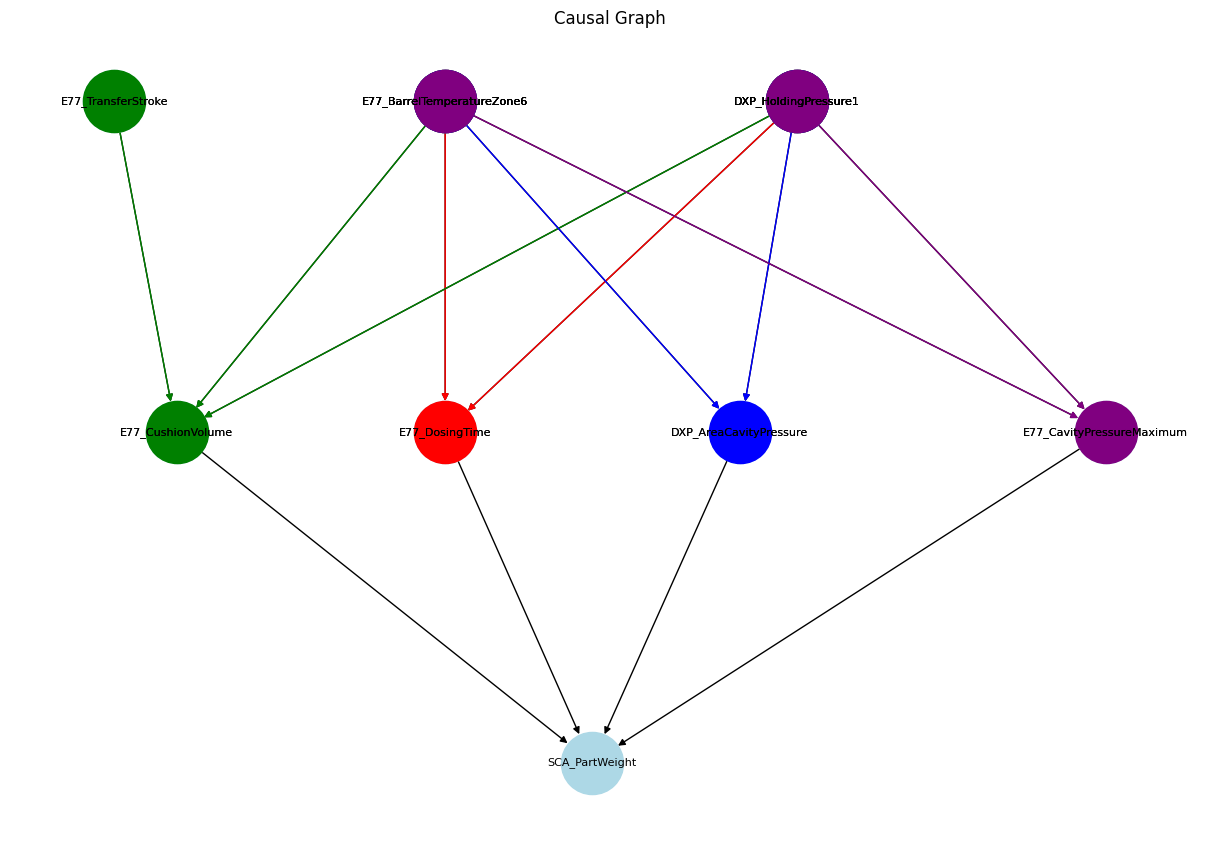

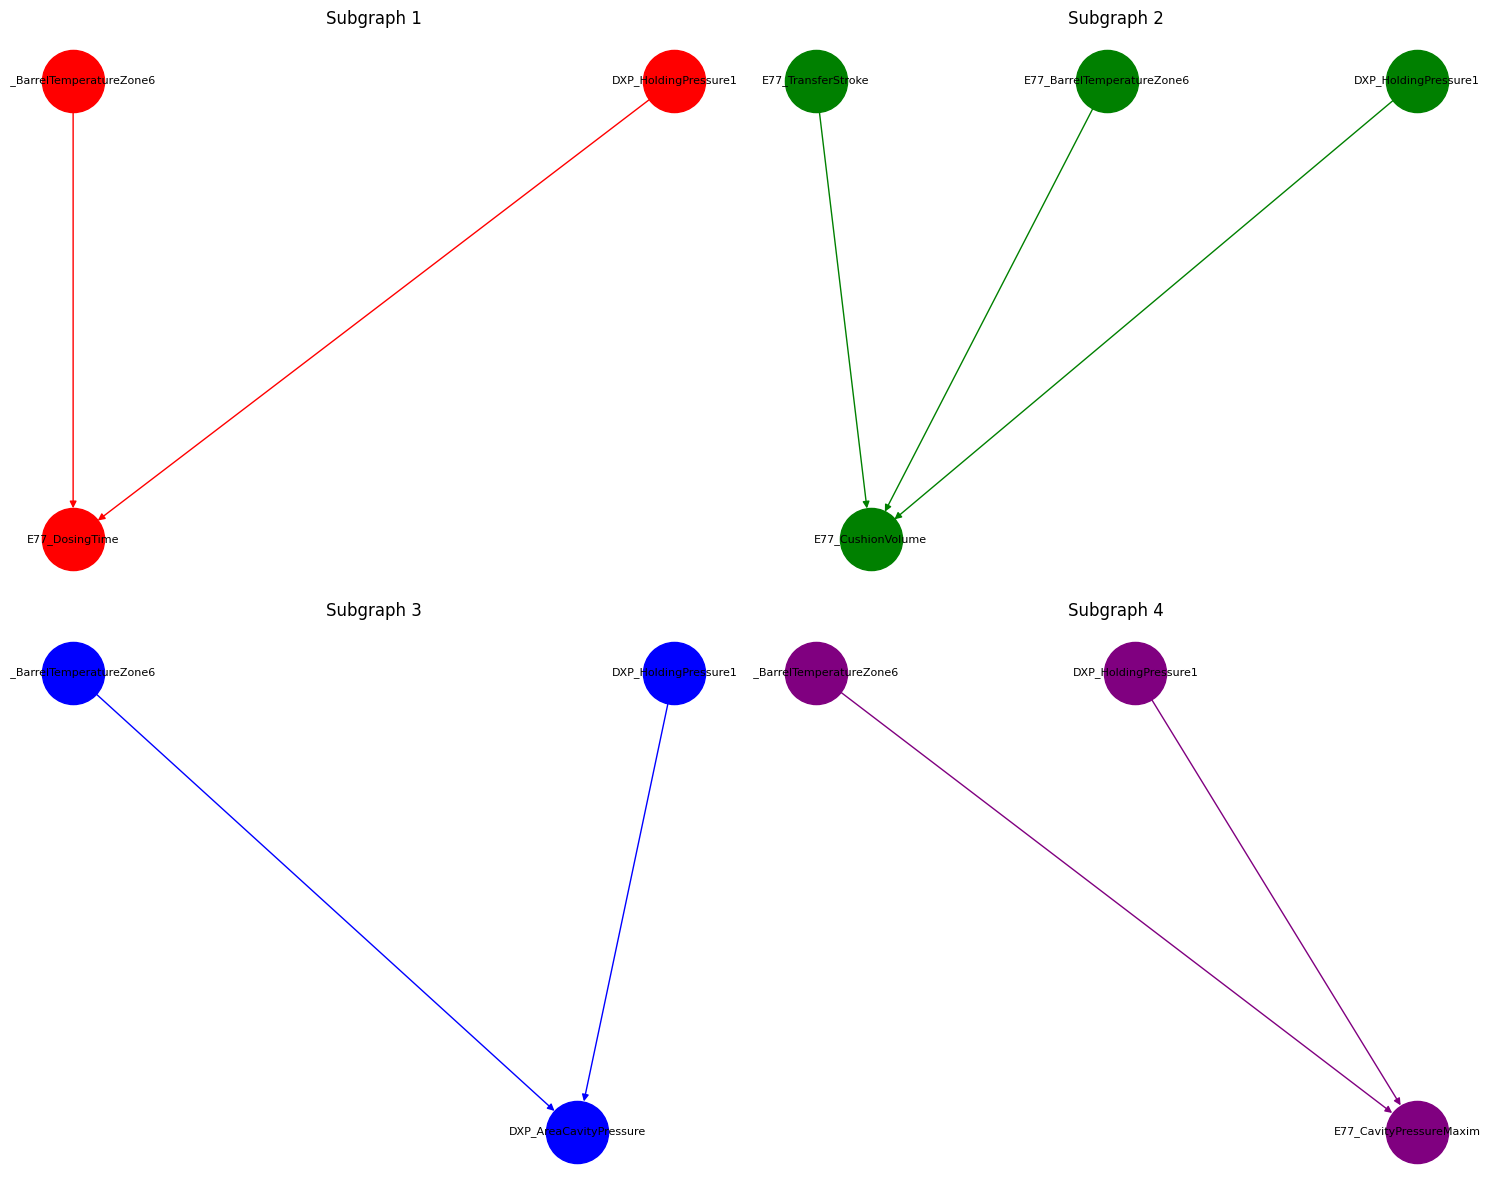

In [6]:
# Define the graph definition
graph_definition = """
digraph {
    E77_DosingTime -> SCA_PartWeight;
    E77_CushionVolume -> SCA_PartWeight;
    DXP_AreaCavityPressure -> SCA_PartWeight;
    E77_CavityPressureMaximum -> SCA_PartWeight;
    DXP_HoldingPressure1 -> E77_DosingTime;
    E77_BarrelTemperatureZone6 -> E77_DosingTime;
    DXP_HoldingPressure1 -> E77_CushionVolume;
    E77_BarrelTemperatureZone6 -> E77_CushionVolume;
    E77_TransferStroke -> E77_CushionVolume;
    DXP_HoldingPressure1 -> E77_CavityPressureMaximum;
    E77_BarrelTemperatureZone6 -> E77_CavityPressureMaximum;
    DXP_HoldingPressure1 -> DXP_AreaCavityPressure;
    E77_BarrelTemperatureZone6 -> DXP_AreaCavityPressure;
}
"""

# Create the NetworkX graph from the graph definition
(graph,) = pydot.graph_from_dot_data(graph_definition)
G = nx.DiGraph(nx.drawing.nx_pydot.from_pydot(graph))

# Define subgraphs
subgraphs = [
    (['DXP_HoldingPressure1', 'E77_BarrelTemperatureZone6', 'E77_DosingTime'], 'Subgraph 1'),
    (['DXP_HoldingPressure1', 'E77_BarrelTemperatureZone6', 'E77_TransferStroke', 'E77_CushionVolume'], 'Subgraph 2'),
    (['DXP_HoldingPressure1', 'E77_BarrelTemperatureZone6', 'DXP_AreaCavityPressure'], 'Subgraph 3'),
    (['DXP_HoldingPressure1', 'E77_BarrelTemperatureZone6', 'E77_CavityPressureMaximum'], 'Subgraph 4')
]

# Visualize the main graph and subgraphs
pos = graphviz_layout(G, prog='dot')
plt.figure(figsize=(12, 8))

# Draw the main graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=8, arrows=True)
plt.title("Causal Graph")

# Draw subgraphs with different colors
colors = ['red', 'green', 'blue', 'purple']
for i, (nodes, _) in enumerate(subgraphs):
    subgraph = G.subgraph(nodes)
    nx.draw(subgraph, pos, with_labels=True, node_color=colors[i], node_size=2000, font_size=8, arrows=True, edge_color=colors[i])

plt.show()

# Visualize each subgraph as subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, (nodes, title) in enumerate(subgraphs):
    subgraph = G.subgraph(nodes)
    nx.draw(subgraph, pos, with_labels=True, node_color=colors[i], node_size=2000, font_size=8, arrows=True, edge_color=colors[i], ax=axes[i])
    axes[i].set_title(title)

plt.tight_layout()
plt.show()

## Graph Refutation

Test permutations of given graph: 100%|██████████| 40320/40320 [04:44<00:00, 141.82it/s]


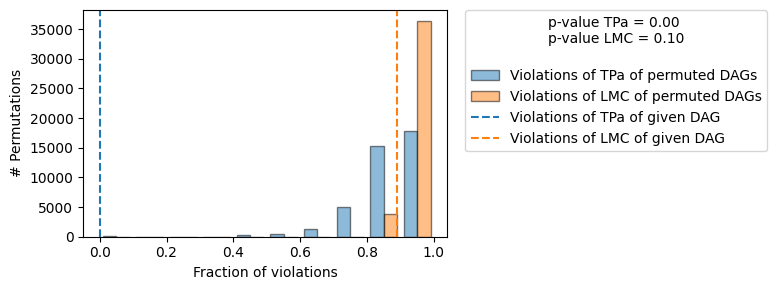

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is informative because 12 / 40320 of the permutations lie in the Markov                 |
| equivalence class of the given DAG (p-value: 0.00).                                                   |
| The given DAG violates 24/27 LMCs and is better than 90.2% of the permuted DAGs (p-value: 0.10).      |
| Based on the provided significance level (0.05) and because the DAG is informative,                   |
| we reject the DAG.                                                                                    |
+-------------------------------------------------------------------------------------------------------+
|                                             

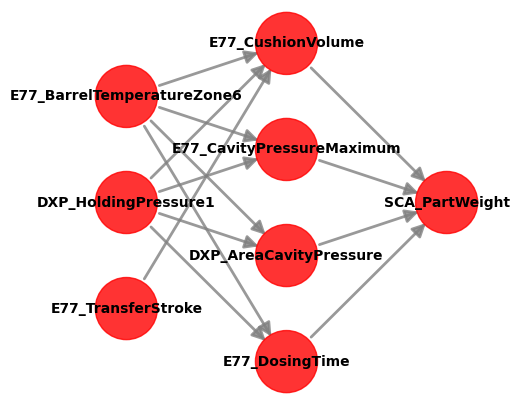

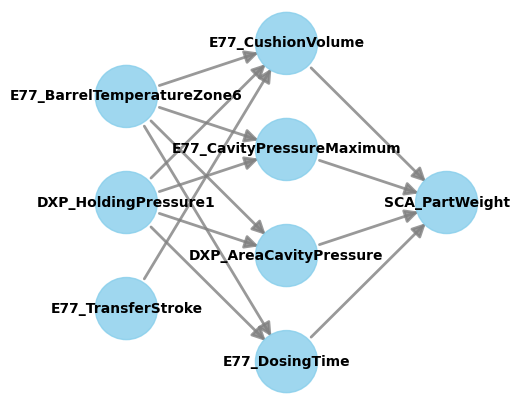

In [7]:
# Perform graph refutation with factorial permutations
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    result = falsify_graph(G, df, plot_histogram=True, show_progress_bar=True,suggestions=True, n_permutations= -1) #n_permutations= -1 for n! permutations

# Print the results
print(result)

# Check if the graph is falsifiable or falsified
print(f"Graph is falsifiable: {result.falsifiable}")
print(f"Graph is falsified: {result.falsified}")

summary = result.summary
lmc_violations = summary[FalsifyConst.VALIDATE_LMC]   
tpa_violations = summary[FalsifyConst.VALIDATE_TPA]

# Print the p-values
print(f"p_value_lmc: {lmc_violations[FalsifyConst.P_VALUE]}")
print(f"p_value_tpa: {tpa_violations[FalsifyConst.P_VALUE]}")

print("LMC Violations summary:")
print(json.dumps({str(k): str(v) for k, v in lmc_violations.items()}, indent=2))

print("TPa Violations summary:")
print(json.dumps({str(k): str(v) for k, v in tpa_violations.items()}, indent=2))

# Analyze the local LMC violations and sort by p-value (ascending)
def analyze_lmc_violations(lmc_violations, p_value_threshold=0.05):
    local_violations = lmc_violations[FalsifyConst.LOCAL_VIOLATION_INSIGHT]
    violations = []
    non_violations = []

    # Collect all violations and non-violations with their p-values
    for (node1, node2), (p_value, is_violation) in local_violations.items():
        result = f"{'LMC violation' if is_violation else 'No LMC violation'} between {node1} and {node2} (p-value: {p_value:.6e})"
        (violations if is_violation else non_violations).append((p_value, node1, node2, result))

    # Sort violations in ascending order (smallest p-value = strongest violation)
    violations.sort(key=lambda x: x[0])

    # Sort non-violations in descending order (for display purposes)
    non_violations.sort(key=lambda x: x[0], reverse=True)

    # Display results
    print(f"Analysis using p-value threshold: {p_value_threshold}")
    print(f"\nViolations ({len(violations)}/{len(local_violations)}, {len(violations)/len(local_violations):.2%}):")
    print("\n".join(result for _, _, _, result in violations) if violations else "No violations found.")
    
    print(f"\nNon-violations ({len(non_violations)}/{len(local_violations)}, {len(non_violations)/len(local_violations):.2%}):")
    print("\n".join(result for _, _, _, result in non_violations) if non_violations else "No non-violations found.")
    
    return violations  # Return sorted violations for further processing
    
analyze_lmc_violations(lmc_violations)

# Plot local insights
print('Violations of LMCs Visualized')
plot_local_insights(G, result, method=FalsifyConst.VALIDATE_LMC)
plt.show()

plot_local_insights(G, result, method=FalsifyConst.VALIDATE_CM)
plt.show()

# New Graph Using Insights from Local LMC Violations

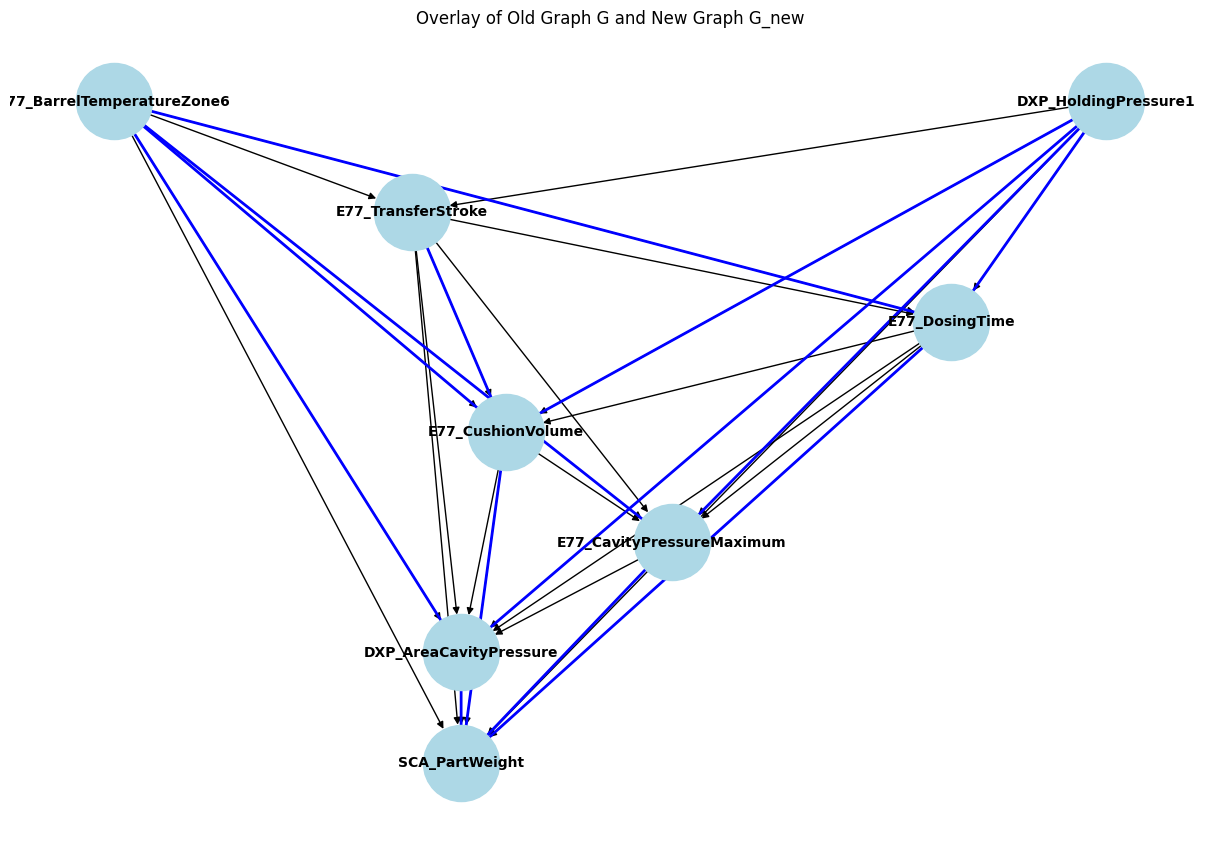

Structural Hamming Distance between expert-derived and modified combined graphs: 14


In [8]:
# Define machine parameters and process parameters
machine_parameters = {'E77_BarrelTemperatureZone6', 'E77_TransferStroke', 'DXP_HoldingPressure1'}
process_parameters = {'E77_CavityPressureMaximum', 'E77_CushionVolume', 'E77_DosingTime', 'DXP_AreaCavityPressure'}

# Initialize directed graph
G_new = nx.DiGraph()

# Add edges between machine parameters
G_new.add_edges_from([
    ('E77_BarrelTemperatureZone6', 'E77_TransferStroke'),
    ('DXP_HoldingPressure1', 'E77_TransferStroke'),
])

# Add edges between process parameters
G_new.add_edges_from([
    ('E77_DosingTime', 'E77_CushionVolume'),
    ('E77_DosingTime', 'E77_CavityPressureMaximum'),
    ('E77_DosingTime', 'DXP_AreaCavityPressure'),
    ('E77_CushionVolume', 'DXP_AreaCavityPressure'),
    ('E77_CushionVolume', 'E77_CavityPressureMaximum'),
    ('E77_CavityPressureMaximum', 'DXP_AreaCavityPressure'),
])

# Add edges from machine parameters to process parameters
G_new.add_edges_from([
    ('E77_TransferStroke', 'E77_CushionVolume'),
    ('E77_TransferStroke', 'E77_CavityPressureMaximum'),
    ('E77_TransferStroke', 'DXP_AreaCavityPressure'),
    ('E77_TransferStroke', 'E77_DosingTime'),
    ('E77_BarrelTemperatureZone6', 'E77_CushionVolume'),
    ('E77_BarrelTemperatureZone6', 'E77_CavityPressureMaximum'),
    ('E77_BarrelTemperatureZone6', 'DXP_AreaCavityPressure'),
    ('E77_BarrelTemperatureZone6', 'E77_DosingTime'),
    ('DXP_HoldingPressure1', 'E77_CushionVolume'),
    ('DXP_HoldingPressure1', 'E77_CavityPressureMaximum'),
    ('DXP_HoldingPressure1', 'DXP_AreaCavityPressure'),
    ('DXP_HoldingPressure1', 'E77_DosingTime')
])

# Add edges to SCA_PartWeight from process parameters and machine parameters
G_new.add_edges_from([
    ('E77_TransferStroke', 'SCA_PartWeight'),
    ('E77_DosingTime', 'SCA_PartWeight'),
    ('E77_CushionVolume', 'SCA_PartWeight'),
    ('DXP_AreaCavityPressure', 'SCA_PartWeight'),
    ('E77_CavityPressureMaximum', 'SCA_PartWeight'),
    ('DXP_HoldingPressure1', 'SCA_PartWeight'),
    ('E77_BarrelTemperatureZone6', 'SCA_PartWeight')
])

# Compare the new graph to the original graph using Structural Hamming Distance
def structural_hamming_distance(G1, G2):
    edges1 = set(G1.edges())
    edges2 = set(G2.edges())
    return len(edges1.symmetric_difference(edges2))

# Overlay the old graph G on top of the new graph G_new
pos = graphviz_layout(G_new, prog='dot')
plt.figure(figsize=(12, 8))

# Draw the new graph G_new with black edges
nx.draw(G_new, pos, with_labels=True, node_color='lightblue', edge_color='black', node_size=3000, font_size=10, font_weight='bold')

# Draw the old graph G with blue edges
nx.draw_networkx_edges(G, pos, edge_color='blue', width=2)

plt.title('Overlay of Old Graph G and New Graph G_new')
plt.show()

# Compute the SHD between the expert-derived graph and the modified combined graph
shd = structural_hamming_distance(G, G_new)
print(f"Structural Hamming Distance between expert-derived and modified combined graphs: {shd}")

Test permutations of given graph: 100%|██████████| 40320/40320 [01:39<00:00, 403.53it/s]


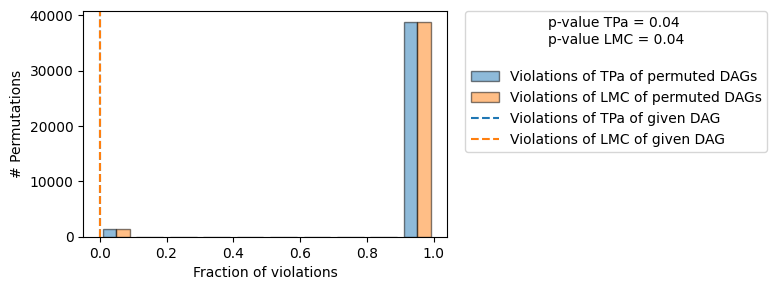

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is informative because 1440 / 40320 of the permutations lie in the Markov               |
| equivalence class of the given DAG (p-value: 0.04).                                                   |
| The given DAG violates 0/2 LMCs and is better than 96.4% of the permuted DAGs (p-value: 0.04).        |
| Based on the provided significance level (0.05) and because the DAG is informative,                   |
| we do not reject the DAG.                                                                             |
+-------------------------------------------------------------------------------------------------------+
{
  "FalsifyConst.PERM_VIOLATIONS": "[0, 0, 0,

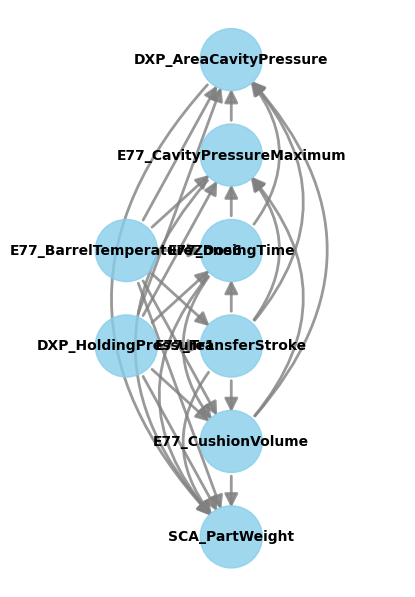

In [9]:
# Perform graph refutation with factorial permutations
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    result = falsify_graph(G_new, df, plot_histogram=True, show_progress_bar=True, n_permutations= -1)

# Print the results
print(result)

summary = result.summary
print(json.dumps({str(k): str(v) for k, v in summary[FalsifyConst.VALIDATE_LMC].items()}, indent=2))

# Print the p-values
print(f"p_value_lmc: {summary[FalsifyConst.VALIDATE_LMC][FalsifyConst.P_VALUE]}")
print(f"p_value_tpa: {summary[FalsifyConst.VALIDATE_TPA][FalsifyConst.P_VALUE]}")
print(f"LMCs: {summary[FalsifyConst.VALIDATE_LMC][FalsifyConst.LOCAL_VIOLATION_INSIGHT]}")

# Plot local insights
print('Violations of LMCs Visualized')
plot_local_insights(G_new, result, method=FalsifyConst.VALIDATE_LMC)
plt.show()

Analysis using p-value threshold: 0.05

Violations (24/27, 88.89%):
LMC violation between E77_DosingTime and E77_TransferStroke (p-value: 0.000000e+00)
LMC violation between SCA_PartWeight and DXP_HoldingPressure1 (p-value: 0.000000e+00)
LMC violation between E77_CavityPressureMaximum and E77_TransferStroke (p-value: 0.000000e+00)
LMC violation between E77_BarrelTemperatureZone6 and E77_TransferStroke (p-value: 0.000000e+00)
LMC violation between E77_TransferStroke and E77_BarrelTemperatureZone6 (p-value: 0.000000e+00)
LMC violation between E77_TransferStroke and E77_DosingTime (p-value: 0.000000e+00)
LMC violation between E77_TransferStroke and DXP_AreaCavityPressure (p-value: 0.000000e+00)
LMC violation between E77_DosingTime and DXP_AreaCavityPressure (p-value: 3.996803e-15)
LMC violation between DXP_AreaCavityPressure and E77_DosingTime (p-value: 3.996803e-15)
LMC violation between E77_DosingTime and E77_CushionVolume (p-value: 1.409983e-14)
LMC violation between DXP_AreaCavityPres

Test permutations of given graph: 100%|██████████| 40320/40320 [02:15<00:00, 298.08it/s]


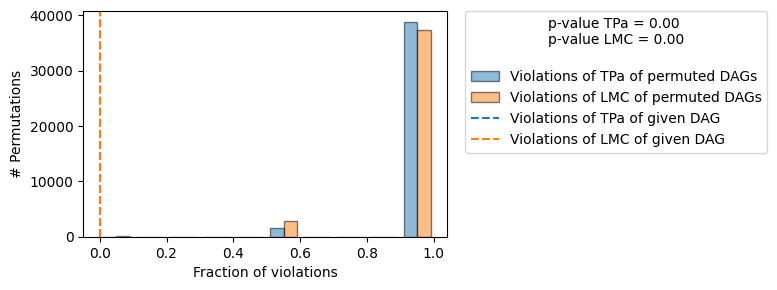

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is informative because 16 / 40320 of the permutations lie in the Markov                 |
| equivalence class of the given DAG (p-value: 0.00).                                                   |
| The given DAG violates 0/4 LMCs and is better than 99.8% of the permuted DAGs (p-value: 0.00).        |
| Based on the provided significance level (0.05) and because the DAG is informative,                   |
| we do not reject the DAG.                                                                             |
+-------------------------------------------------------------------------------------------------------+
Violations of LMCs Visualized


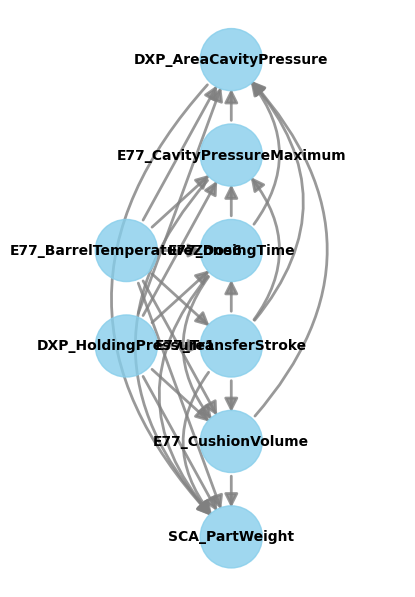


Iteration 2:
Edge E77_CushionVolume <-> E77_CavityPressureMaximum does not exist in the graph. Skipping...
Removing edge: E77_TransferStroke -> SCA_PartWeight
Violation description: LMC violation between SCA_PartWeight and E77_TransferStroke (p-value: 3.364113e-04)
Performing graph refutation...


Test permutations of given graph: 100%|██████████| 40320/40320 [02:30<00:00, 268.66it/s]


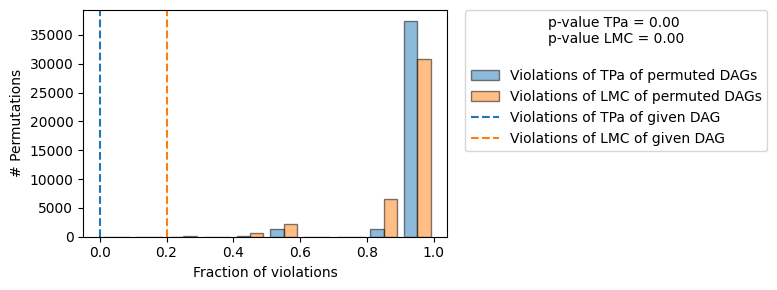

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is informative because 4 / 40320 of the permutations lie in the Markov                  |
| equivalence class of the given DAG (p-value: 0.00).                                                   |
| The given DAG violates 1/5 LMCs and is better than 99.8% of the permuted DAGs (p-value: 0.00).        |
| Based on the provided significance level (0.05) and because the DAG is informative,                   |
| we do not reject the DAG.                                                                             |
+-------------------------------------------------------------------------------------------------------+
Violations of LMCs Visualized


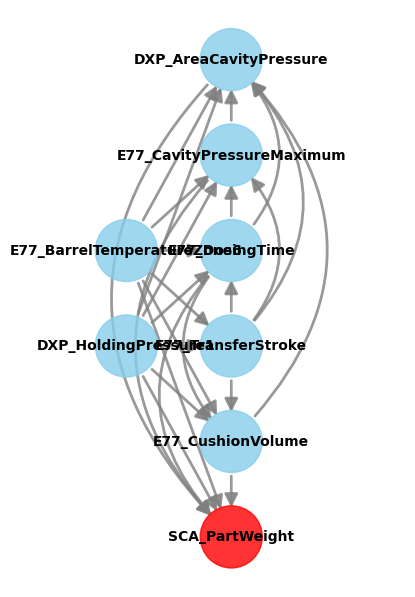


Iteration 3:
Removing edge: E77_CavityPressureMaximum -> DXP_AreaCavityPressure
Violation description: LMC violation between E77_CavityPressureMaximum and DXP_AreaCavityPressure (p-value: 4.795641e-05)
Performing graph refutation...


Test permutations of given graph: 100%|██████████| 40320/40320 [03:07<00:00, 214.65it/s]


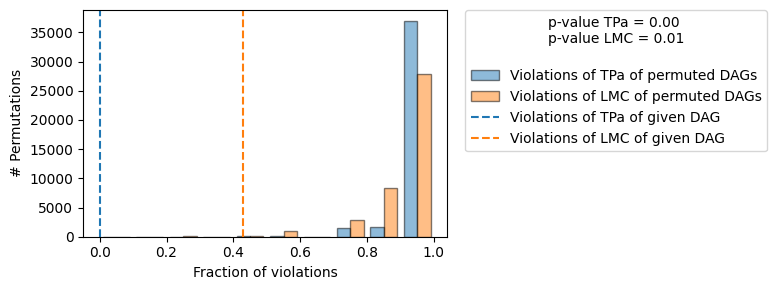

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is informative because 4 / 40320 of the permutations lie in the Markov                  |
| equivalence class of the given DAG (p-value: 0.00).                                                   |
| The given DAG violates 3/7 LMCs and is better than 99.4% of the permuted DAGs (p-value: 0.01).        |
| Based on the provided significance level (0.05) and because the DAG is informative,                   |
| we do not reject the DAG.                                                                             |
+-------------------------------------------------------------------------------------------------------+
Violations of LMCs Visualized


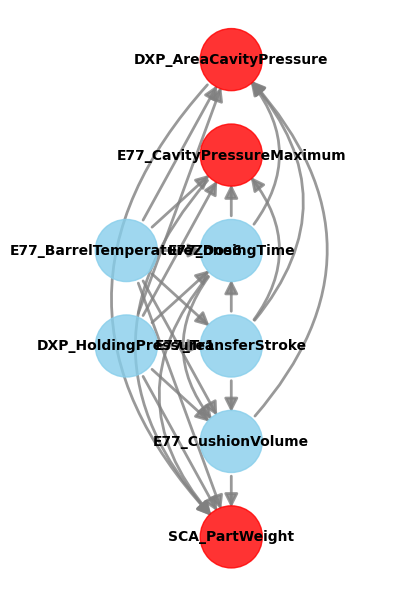


Iteration 4:
Edge DXP_AreaCavityPressure <-> E77_CavityPressureMaximum does not exist in the graph. Skipping...
Removing edge: E77_CushionVolume -> DXP_AreaCavityPressure
Violation description: LMC violation between E77_CushionVolume and DXP_AreaCavityPressure (p-value: 5.863604e-07)
Performing graph refutation...


Test permutations of given graph: 100%|██████████| 40320/40320 [02:21<00:00, 284.01it/s]


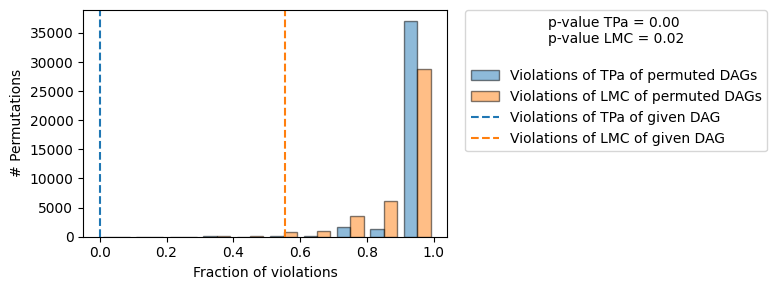

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is informative because 12 / 40320 of the permutations lie in the Markov                 |
| equivalence class of the given DAG (p-value: 0.00).                                                   |
| The given DAG violates 5/9 LMCs and is better than 97.7% of the permuted DAGs (p-value: 0.02).        |
| Based on the provided significance level (0.05) and because the DAG is informative,                   |
| we do not reject the DAG.                                                                             |
+-------------------------------------------------------------------------------------------------------+
Violations of LMCs Visualized


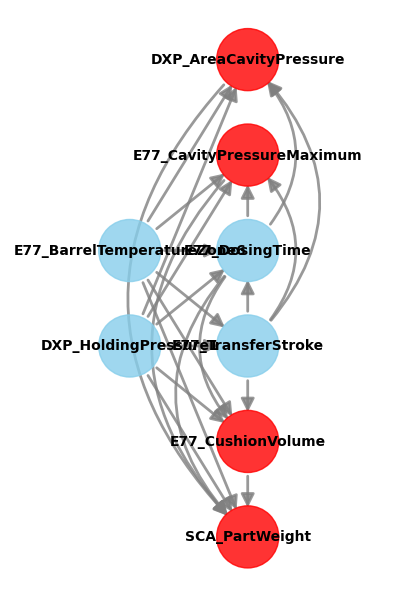


Iteration 5:
Removing edge: DXP_HoldingPressure1 -> E77_TransferStroke
Violation description: LMC violation between E77_TransferStroke and DXP_HoldingPressure1 (p-value: 3.186625e-07)
Performing graph refutation...


Test permutations of given graph: 100%|██████████| 40320/40320 [02:49<00:00, 237.26it/s]


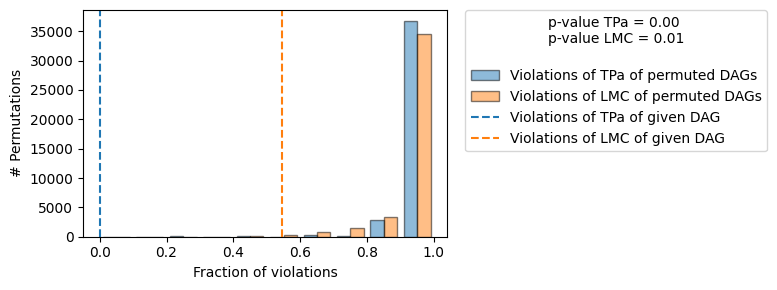

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is informative because 6 / 40320 of the permutations lie in the Markov                  |
| equivalence class of the given DAG (p-value: 0.00).                                                   |
| The given DAG violates 6/11 LMCs and is better than 99.3% of the permuted DAGs (p-value: 0.01).       |
| Based on the provided significance level (0.05) and because the DAG is informative,                   |
| we do not reject the DAG.                                                                             |
+-------------------------------------------------------------------------------------------------------+
Violations of LMCs Visualized


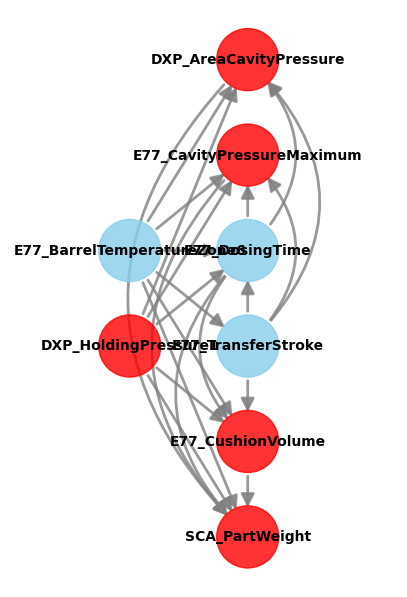


Iteration 6:
Edge DXP_HoldingPressure1 <-> E77_TransferStroke does not exist in the graph. Skipping...
Removing edge: E77_TransferStroke -> E77_CavityPressureMaximum
Violation description: LMC violation between E77_TransferStroke and E77_CavityPressureMaximum (p-value: 1.130131e-08)
Performing graph refutation...


Test permutations of given graph: 100%|██████████| 40320/40320 [03:45<00:00, 178.82it/s]


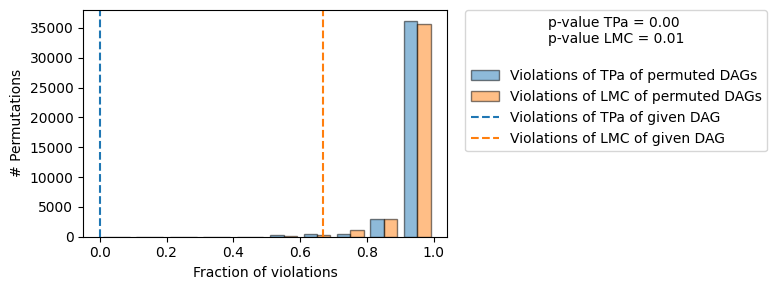

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is informative because 2 / 40320 of the permutations lie in the Markov                  |
| equivalence class of the given DAG (p-value: 0.00).                                                   |
| The given DAG violates 8/12 LMCs and is better than 98.9% of the permuted DAGs (p-value: 0.01).       |
| Based on the provided significance level (0.05) and because the DAG is informative,                   |
| we do not reject the DAG.                                                                             |
+-------------------------------------------------------------------------------------------------------+
Violations of LMCs Visualized


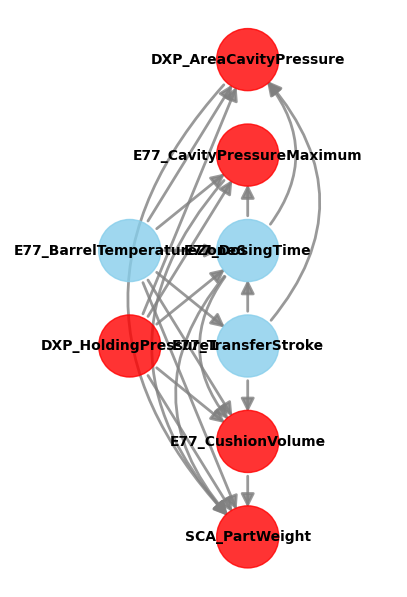


Iteration 7:
Removing edge: E77_DosingTime -> E77_CushionVolume
Violation description: LMC violation between E77_CushionVolume and E77_DosingTime (p-value: 3.683646e-09)
Performing graph refutation...


Test permutations of given graph: 100%|██████████| 40320/40320 [03:46<00:00, 178.03it/s]


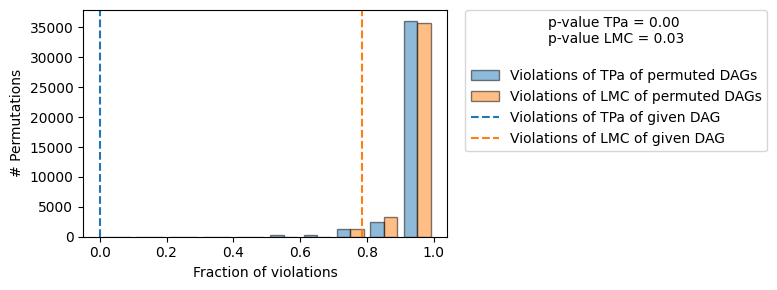

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is informative because 1 / 40320 of the permutations lie in the Markov                  |
| equivalence class of the given DAG (p-value: 0.00).                                                   |
| The given DAG violates 11/14 LMCs and is better than 96.8% of the permuted DAGs (p-value: 0.03).      |
| Based on the provided significance level (0.05) and because the DAG is informative,                   |
| we do not reject the DAG.                                                                             |
+-------------------------------------------------------------------------------------------------------+
Violations of LMCs Visualized


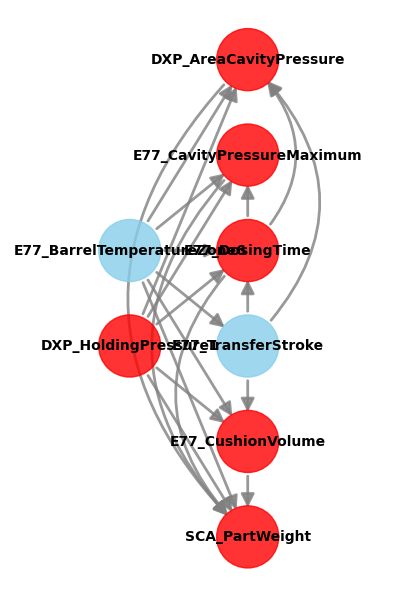


Iteration 8:
Removing edge: E77_DosingTime -> E77_CavityPressureMaximum
Violation description: LMC violation between E77_CavityPressureMaximum and E77_DosingTime (p-value: 2.260255e-09)
Performing graph refutation...


Test permutations of given graph: 100%|██████████| 40320/40320 [05:56<00:00, 113.08it/s]


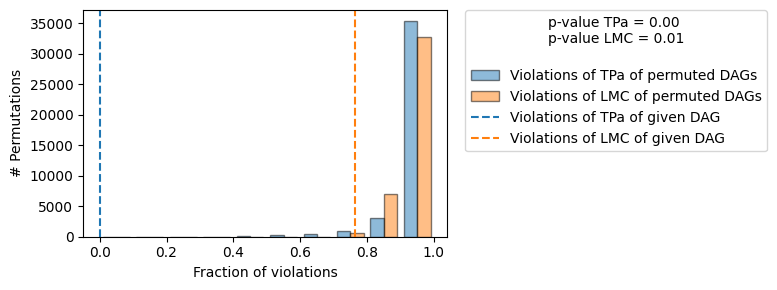

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is informative because 2 / 40320 of the permutations lie in the Markov                  |
| equivalence class of the given DAG (p-value: 0.00).                                                   |
| The given DAG violates 13/17 LMCs and is better than 98.6% of the permuted DAGs (p-value: 0.01).      |
| Based on the provided significance level (0.05) and because the DAG is informative,                   |
| we do not reject the DAG.                                                                             |
+-------------------------------------------------------------------------------------------------------+
Violations of LMCs Visualized


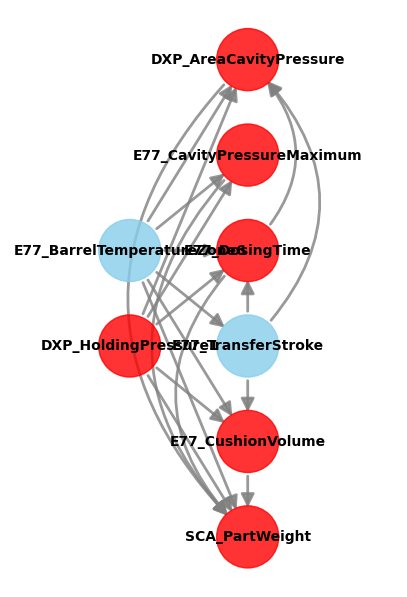


Iteration 9:
Edge E77_DosingTime <-> E77_CavityPressureMaximum does not exist in the graph. Skipping...
Removing edge: E77_BarrelTemperatureZone6 -> SCA_PartWeight
Violation description: LMC violation between SCA_PartWeight and E77_BarrelTemperatureZone6 (p-value: 1.084577e-12)
Performing graph refutation...


Test permutations of given graph: 100%|██████████| 40320/40320 [06:01<00:00, 111.48it/s]


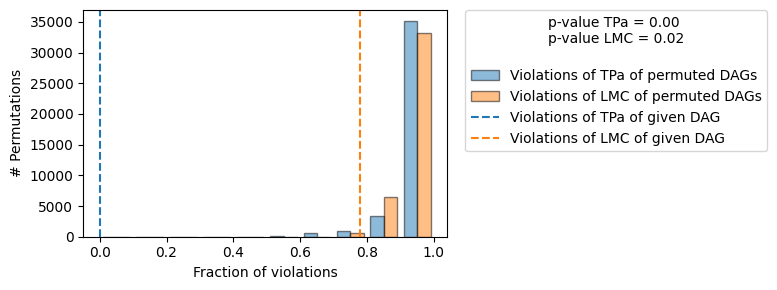

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is informative because 2 / 40320 of the permutations lie in the Markov                  |
| equivalence class of the given DAG (p-value: 0.00).                                                   |
| The given DAG violates 14/18 LMCs and is better than 98.5% of the permuted DAGs (p-value: 0.02).      |
| Based on the provided significance level (0.05) and because the DAG is informative,                   |
| we do not reject the DAG.                                                                             |
+-------------------------------------------------------------------------------------------------------+
Violations of LMCs Visualized


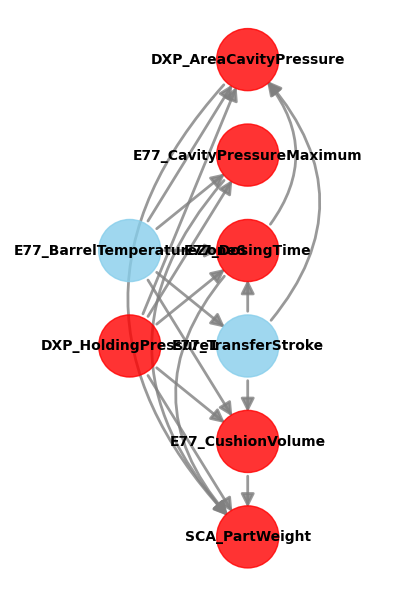


Iteration 10:
Edge DXP_AreaCavityPressure <-> E77_CushionVolume does not exist in the graph. Skipping...
Edge E77_DosingTime <-> E77_CushionVolume does not exist in the graph. Skipping...
Removing edge: E77_DosingTime -> DXP_AreaCavityPressure
Violation description: LMC violation between DXP_AreaCavityPressure and E77_DosingTime (p-value: 3.996803e-15)
Performing graph refutation...


Test permutations of given graph: 100%|██████████| 40320/40320 [03:48<00:00, 176.44it/s]


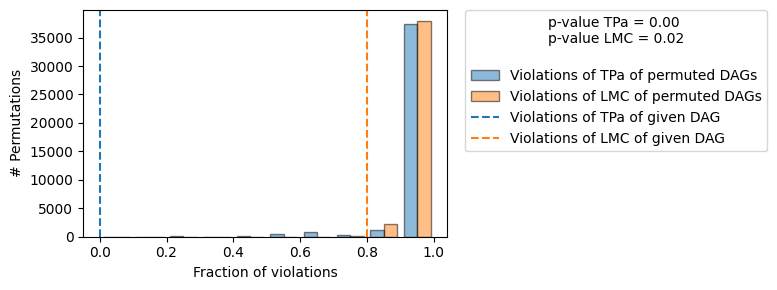

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is informative because 6 / 40320 of the permutations lie in the Markov                  |
| equivalence class of the given DAG (p-value: 0.00).                                                   |
| The given DAG violates 16/20 LMCs and is better than 98.1% of the permuted DAGs (p-value: 0.02).      |
| Based on the provided significance level (0.05) and because the DAG is informative,                   |
| we do not reject the DAG.                                                                             |
+-------------------------------------------------------------------------------------------------------+
Violations of LMCs Visualized


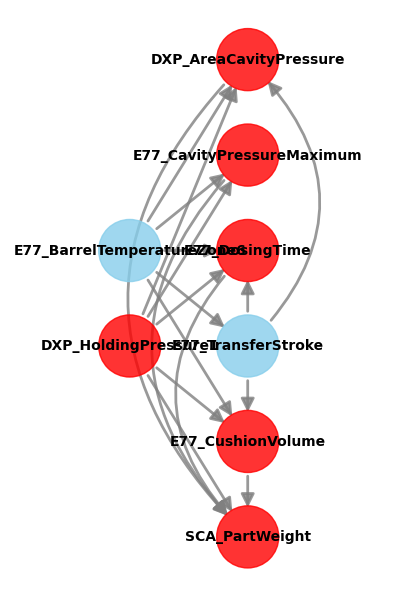


Iteration 11:
Edge E77_DosingTime <-> DXP_AreaCavityPressure does not exist in the graph. Skipping...
Removing edge: E77_TransferStroke -> DXP_AreaCavityPressure
Violation description: LMC violation between E77_TransferStroke and DXP_AreaCavityPressure (p-value: 0.000000e+00)
Performing graph refutation...


Test permutations of given graph: 100%|██████████| 40320/40320 [02:43<00:00, 246.52it/s]


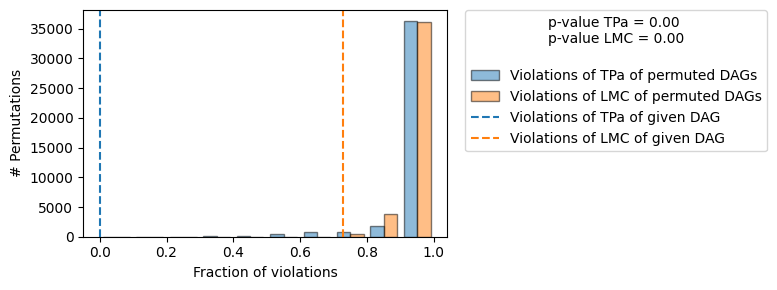

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is informative because 4 / 40320 of the permutations lie in the Markov                  |
| equivalence class of the given DAG (p-value: 0.00).                                                   |
| The given DAG violates 16/22 LMCs and is better than 99.8% of the permuted DAGs (p-value: 0.00).      |
| Based on the provided significance level (0.05) and because the DAG is informative,                   |
| we do not reject the DAG.                                                                             |
+-------------------------------------------------------------------------------------------------------+
Violations of LMCs Visualized


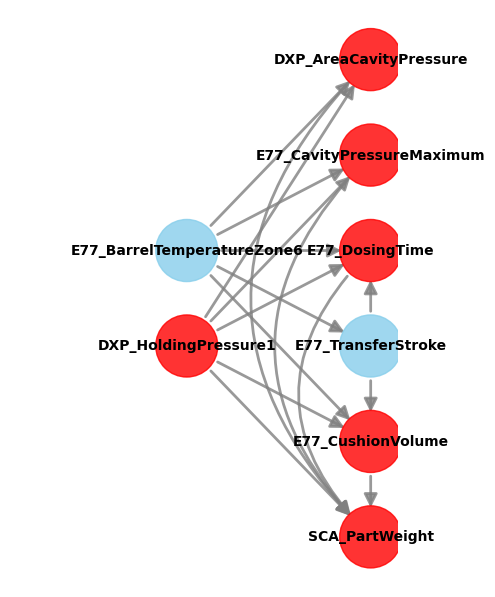


Iteration 12:
Removing edge: E77_TransferStroke -> E77_DosingTime
Violation description: LMC violation between E77_TransferStroke and E77_DosingTime (p-value: 0.000000e+00)
Performing graph refutation...


Test permutations of given graph: 100%|██████████| 40320/40320 [02:54<00:00, 231.72it/s]


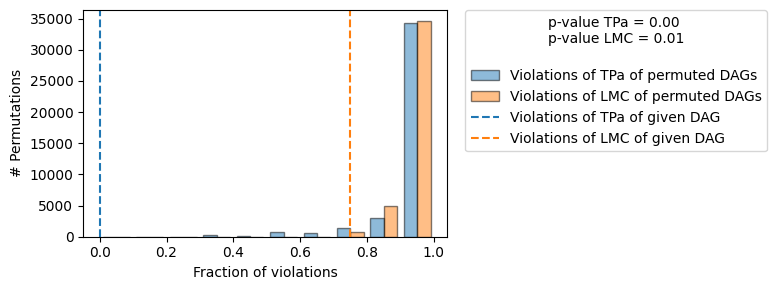

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is informative because 6 / 40320 of the permutations lie in the Markov                  |
| equivalence class of the given DAG (p-value: 0.00).                                                   |
| The given DAG violates 18/24 LMCs and is better than 99.5% of the permuted DAGs (p-value: 0.01).      |
| Based on the provided significance level (0.05) and because the DAG is informative,                   |
| we do not reject the DAG.                                                                             |
+-------------------------------------------------------------------------------------------------------+
Violations of LMCs Visualized


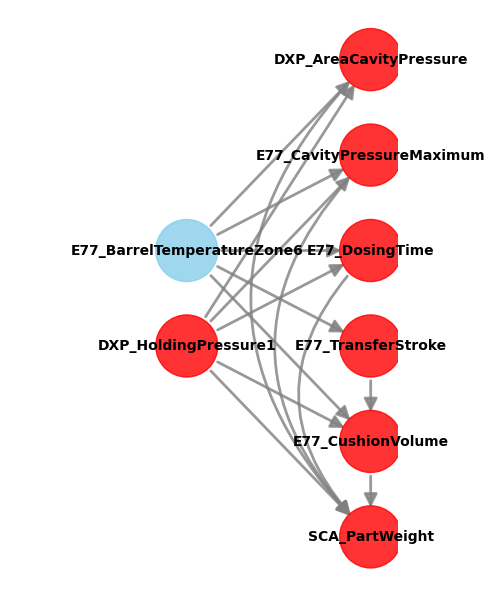


Iteration 13:
Removing edge: E77_BarrelTemperatureZone6 -> E77_TransferStroke
Violation description: LMC violation between E77_TransferStroke and E77_BarrelTemperatureZone6 (p-value: 0.000000e+00)
Performing graph refutation...


Test permutations of given graph: 100%|██████████| 40320/40320 [02:55<00:00, 229.61it/s]


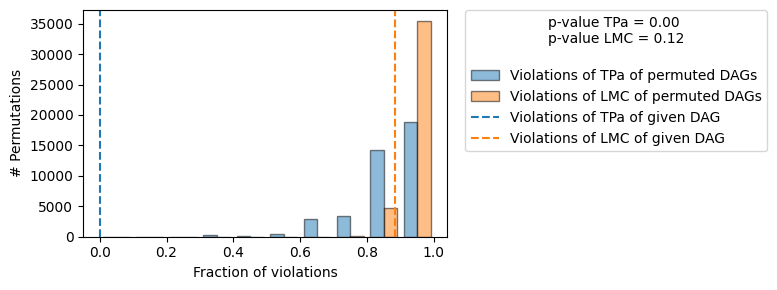

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is informative because 6 / 40320 of the permutations lie in the Markov                  |
| equivalence class of the given DAG (p-value: 0.00).                                                   |
| The given DAG violates 23/26 LMCs and is better than 88.0% of the permuted DAGs (p-value: 0.12).      |
| Based on the provided significance level (0.05) and because the DAG is informative,                   |
| we reject the DAG.                                                                                    |
+-------------------------------------------------------------------------------------------------------+
Violations of LMCs Visualized


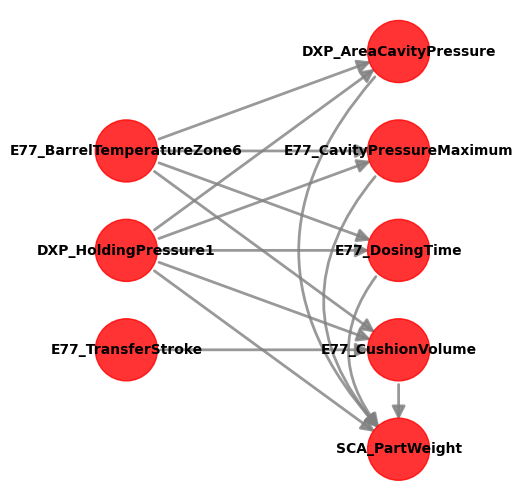

The graph is now falsified.


In [10]:
def iterative_refutation_modification(graph, df, lmc_violations, G_target):
    # Use the violations list as-is, already sorted from strongest to least strong
    violations_list = analyze_lmc_violations(lmc_violations).copy()  # Create a copy to avoid modifying the original
    
    iteration = 0
    G_copy = graph.copy()  # Create a copy of the original graph

    while violations_list:
        iteration += 1
        print(f"\nIteration {iteration}:")

        # Find the least strong violation that exists in the graph
        valid_edge_found = False
        while violations_list and not valid_edge_found:
            p_value, parent, node, violation_desc = violations_list.pop()  # Get the last element (least strong violation)
            
            if G_copy.has_edge(parent, node):
                print(f"Removing edge: {parent} -> {node}")
                print(f"Violation description: {violation_desc}")
                G_copy.remove_edge(parent, node)
                valid_edge_found = True
            elif G_copy.has_edge(node, parent):
                print(f"Removing edge: {node} -> {parent}")
                print(f"Violation description: {violation_desc}")
                G_copy.remove_edge(node, parent)
                valid_edge_found = True
            else:
                print(f"Edge {parent} <-> {node} does not exist in the graph. Skipping...")

        if not valid_edge_found:
            print("No more edges found to remove.")
            break

        # Check if the graph is a DAG
        if not nx.is_directed_acyclic_graph(G_copy):
            raise ValueError(f"Graph contains cycles after iteration {iteration}.")

        # Perform graph refutation with factorial permutations
        print("Performing graph refutation...")
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            result = falsify_graph(G_copy, df, plot_histogram=True, show_progress_bar=True, n_permutations=-1)

        # Print the results
        print(result)

        # Plot local insights
        print('Violations of LMCs Visualized')
        plot_local_insights(G_copy, result, method=FalsifyConst.VALIDATE_LMC)
        plt.show()

        # Check if the graph is falsified
        if result.falsified:
            print("The graph is now falsified.")
            break

        # Check if the current graph is equivalent to the target graph
        if nx.is_isomorphic(G_copy, G_target):
            print("The current graph is equivalent to the target graph.")
            break

        # We don't update violations_list here anymore

    return G_copy, result

# Call the function with your parameters
G_final, final_result = iterative_refutation_modification(G_new, df, lmc_violations, G)